## Install Keras

In [1]:
# https://keras.io/
!pip install -q keras
import keras

Using TensorFlow backend.


## Import Packages

In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Concatenate
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.misc import toimage
import time
import math


In [0]:
# this part will prevent tensorflow to allocate all the available GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

## Download Cyclical Learning Rate package 

In [4]:
!rm -rf clr_callback.py*
!wget https://github.com/bckenstler/CLR/raw/master/clr_callback.py
from clr_callback import *

--2018-10-20 02:47:20--  https://github.com/bckenstler/CLR/raw/master/clr_callback.py
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bckenstler/CLR/master/clr_callback.py [following]
--2018-10-20 02:47:20--  https://raw.githubusercontent.com/bckenstler/CLR/master/clr_callback.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5326 (5.2K) [text/plain]
Saving to: ‘clr_callback.py’

clr_callback.py     100%[===================>]   5.20K  --.-KB/s    in 0s      

2018-10-20 02:47:21 (40.4 MB/s) - ‘clr_callback.py’ saved [5326/5326]



## Download LR Finder package 

In [4]:
!rm -rf /content/lr_finder.py*
!wget https://gist.github.com/jeremyjordan/ac0229abd4b2b7000aca1643e88e0f02/raw/3b780822389cb4d96c50e83b59b8a506120fb044/lr_finder.py
!sed -i '1s/^/from keras import backend as K\n/' lr_finder.py
from lr_finder import *

--2018-10-25 14:01:57--  https://gist.github.com/jeremyjordan/ac0229abd4b2b7000aca1643e88e0f02/raw/3b780822389cb4d96c50e83b59b8a506120fb044/lr_finder.py
Resolving gist.github.com (gist.github.com)... 192.30.253.118, 192.30.253.119
Connecting to gist.github.com (gist.github.com)|192.30.253.118|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gist.githubusercontent.com/jeremyjordan/ac0229abd4b2b7000aca1643e88e0f02/raw/3b780822389cb4d96c50e83b59b8a506120fb044/lr_finder.py [following]
--2018-10-25 14:01:58--  https://gist.githubusercontent.com/jeremyjordan/ac0229abd4b2b7000aca1643e88e0f02/raw/3b780822389cb4d96c50e83b59b8a506120fb044/lr_finder.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2847 (2.8K) [text/pla

## Plotting Functions

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## Hyperparameters

In [0]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 50
l = 12
nb_filter = 24
compression = 0.9
dropout_rate = 0.2
growth_rate = 12

## LR Schedule Function

In [0]:
def lr_schedule(epoch):
    #lrate = 0.001
    lrate = 0.01
    if epoch > 75:
        #lrate = 0.0005
        lrate = 0.001
    elif epoch > 150:
        #lrate = 0.0003
        lrate = 0.0001
    return lrate

## LR Step Decay function

In [0]:
# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.1
	drop = 0.5
	epochs_drop = 20.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

## Load and Normalize Data

In [10]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoding 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

170500096/170498071 [==============================] - 16s 0us/step


## Define Densenet Model functions

In [0]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression, growth_rate, nb_filter
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(growth_rate, (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        nb_filter += growth_rate
        temp = concat
        
    return temp

In [0]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter * compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
def output_layer(input):
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    #AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    GlobalAvg = GlobalAveragePooling2D()(relu)
    #flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(GlobalAvg)
    
    return output

## Create Densenet Model

In [ ]:
#num_filter = 24
#dropout_rate = 0.2
#l = 12
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(nb_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, nb_filter, dropout_rate)
First_Transition = add_transition(First_Block, nb_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, nb_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, nb_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, nb_filter, dropout_rate)
#Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

output = output_layer(Third_Block)


In [15]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 24)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 24)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Mount Google Drive for saving and loading weights

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

#model.load_weights("/content/gdrive/My Drive/Model Weights/DNST_CIFAR10/weights_with_aug.best.h5")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Define Data Augmentation

In [0]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

## Initialize SGD

In [0]:
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

## Define checkpoint and callbacks

In [0]:
# checkpoint
filepath="/content/gdrive/My Drive/Model Weights/DNST_CIFAR10/weights_with_lrsch_dropout.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#clr_triangular = CyclicLR(mode='triangular2')
#clr_triangular = CyclicLR(base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular2')
#callbacks_list = [checkpoint]
callbacks_list = [checkpoint, LearningRateScheduler(step_decay)]
#callbacks_list = [checkpoint, clr_triangular]



## Run LR Finder

Epoch 1/1
50000/50000 [==============================] - 341s 7ms/step - loss: 0.6537 - acc: 0.7804


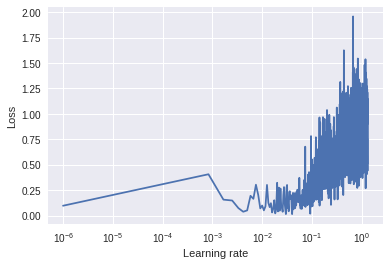

In [33]:
lr_finder = LRFinder(min_lr=1e-6,
                     max_lr=1e-2, 
                     steps_per_epoch=np.ceil(epochs/batch_size), 
                     epochs=3)
model.fit(x_train, y_train, callbacks=[lr_finder])
lr_finder.plot_loss()

## Training - Epochs 1 to 50 (max val_acc: 89.90%)

In [22]:
start = time.time()
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,\
                    verbose=1, validation_data=(x_test,y_test),\
                    callbacks=callbacks_list) 
end = time.time()


Epoch 1/50
781/781 [==============================] - 297s 380ms/step - loss: 1.6295 - acc: 0.4026 - val_loss: 2.2921 - val_acc: 0.3835

Epoch 00001: val_acc improved from -inf to 0.38350, saving model to /content/gdrive/My Drive/Model Weights/DNST_CIFAR10/weights_with_lrsch_dropout.best.h5
Epoch 2/50
781/781 [==============================] - 289s 370ms/step - loss: 1.1709 - acc: 0.5828 - val_loss: 1.3741 - val_acc: 0.5795

Epoch 00002: val_acc improved from 0.38350 to 0.57950, saving model to /content/gdrive/My Drive/Model Weights/DNST_CIFAR10/weights_with_lrsch_dropout.best.h5
Epoch 3/50
781/781 [==============================] - 282s 361ms/step - loss: 0.9801 - acc: 0.6516 - val_loss: 1.2124 - val_acc: 0.6279

Epoch 00003: val_acc improved from 0.57950 to 0.62790, saving model to /content/gdrive/My Drive/Model Weights/DNST_CIFAR10/weights_with_lrsch_dropout.best.h5
Epoch 4/50
781/781 [==============================] - 282s 361ms/step - loss: 0.8449 - acc: 0.7012 - val_loss: 0.8596 

## Training - Epochs 51 to 100 (max val_acc: 91.33%)

In [0]:
start = time.time()
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,\
                    verbose=1, validation_data=(x_test,y_test),\
                    callbacks=callbacks_list) 
end = time.time()


Epoch 1/50
781/781 [==============================] - 293s 375ms/step - loss: 0.2897 - acc: 0.8971 - val_loss: 0.5847 - val_acc: 0.8407

Epoch 00001: val_acc improved from -inf to 0.84070, saving model to /content/gdrive/My Drive/Model Weights/DNST_CIFAR10/weights_3B.best.h5
Epoch 2/50
781/781 [==============================] - 282s 361ms/step - loss: 0.2675 - acc: 0.9055 - val_loss: 0.5162 - val_acc: 0.8547

Epoch 00002: val_acc improved from 0.84070 to 0.85470, saving model to /content/gdrive/My Drive/Model Weights/DNST_CIFAR10/weights_3B.best.h5
Epoch 3/50
781/781 [==============================] - 282s 361ms/step - loss: 0.2661 - acc: 0.9054 - val_loss: 0.5573 - val_acc: 0.8482

Epoch 00003: val_acc did not improve from 0.85470
Epoch 4/50
781/781 [==============================] - 282s 362ms/step - loss: 0.2535 - acc: 0.9112 - val_loss: 0.4239 - val_acc: 0.8750

Epoch 00004: val_acc improved from 0.85470 to 0.87500, saving model to /content/gdrive/My Drive/Model Weights/DNST_CIFAR1

## Training - Epochs 101 to 110 (max val_acc: 91.68%)

In [0]:
start = time.time()
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,\
                    verbose=1, validation_data=(x_test,y_test),\
                    callbacks=callbacks_list) 
end = time.time()


Epoch 1/10
781/781 [==============================] - 291s 373ms/step - loss: 0.0530 - acc: 0.9810 - val_loss: 0.3768 - val_acc: 0.9159

Epoch 00001: val_acc improved from -inf to 0.91590, saving model to /content/gdrive/My Drive/Model Weights/DNST_CIFAR10/weights_3B.best.h5
Epoch 2/10
781/781 [==============================] - 283s 362ms/step - loss: 0.0529 - acc: 0.9817 - val_loss: 0.3738 - val_acc: 0.9161

Epoch 00002: val_acc improved from 0.91590 to 0.91610, saving model to /content/gdrive/My Drive/Model Weights/DNST_CIFAR10/weights_3B.best.h5
Epoch 3/10
781/781 [==============================] - 282s 361ms/step - loss: 0.0534 - acc: 0.9811 - val_loss: 0.3739 - val_acc: 0.9166

Epoch 00003: val_acc improved from 0.91610 to 0.91660, saving model to /content/gdrive/My Drive/Model Weights/DNST_CIFAR10/weights_3B.best.h5
Epoch 4/10
781/781 [==============================] - 282s 361ms/step - loss: 0.0534 - acc: 0.9808 - val_loss: 0.3757 - val_acc: 0.9158

Epoch 00004: val_acc did not 

## Training - Epochs 111 to 139 (max val_acc: 92.18% FINAL)

In [0]:
start = time.time()
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=2*x_train.shape[0] // batch_size,epochs=epochs,\
                    verbose=1, validation_data=(x_test,y_test),\
                    callbacks=callbacks_list) 
end = time.time()


Epoch 1/100
1562/1562 [==============================] - 517s 331ms/step - loss: 0.0259 - acc: 0.9907 - val_loss: 0.4067 - val_acc: 0.9155

Epoch 00001: val_acc improved from -inf to 0.91550, saving model to /content/gdrive/My Drive/Model Weights/DNST_CIFAR10/weights_3B.best.h5
Epoch 2/100
1562/1562 [==============================] - 501s 321ms/step - loss: 0.0207 - acc: 0.9928 - val_loss: 0.3973 - val_acc: 0.9172

Epoch 00002: val_acc improved from 0.91550 to 0.91720, saving model to /content/gdrive/My Drive/Model Weights/DNST_CIFAR10/weights_3B.best.h5
Epoch 3/100
1562/1562 [==============================] - 501s 321ms/step - loss: 0.0196 - acc: 0.9934 - val_loss: 0.3908 - val_acc: 0.9172

Epoch 00003: val_acc did not improve from 0.91720
Epoch 4/100
1562/1562 [==============================] - 501s 320ms/step - loss: 0.0182 - acc: 0.9937 - val_loss: 0.3923 - val_acc: 0.9171

Epoch 00004: val_acc did not improve from 0.91720
Epoch 5/100
1562/1562 [==============================] - 50

## Plot Model History

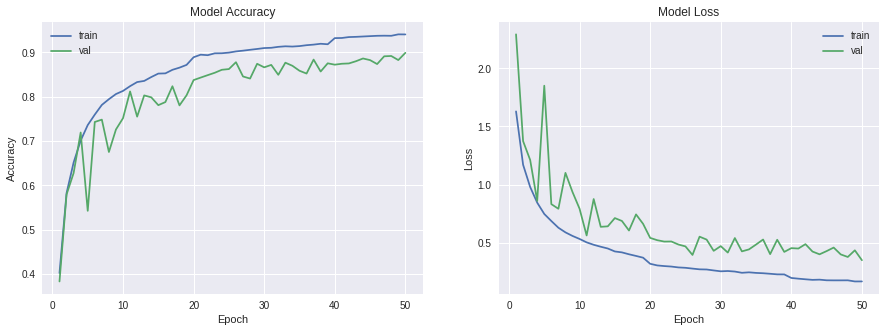

Model took 14145.63 seconds to train
Accuracy on test data is: 89.90


In [23]:
# plot model history
plot_model_history(model_info)
print("Model took %0.2f seconds to train" % (end - start))
# compute test accuracy
print("Accuracy on test data is: %0.2f" % accuracy(x_test, y_test, model))

In [24]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 21s 2ms/step
Test loss: 0.35043127034306526
Test accuracy: 0.899
